# Data Science Jobs Vacancies

In this project, we shall apply **hierarchical clustering** in the [dataset](https://salaries.ai-jobs.net/download/) from the jobseeker website [ai-jobs](https://ai-jobs.net/). The purpose is to cluster job vacancies in the Data Science field by experience levels.

## Libraries

In [114]:
# Data and numerical operations
import numpy as np
import pandas as pd

# Graph and Charts
from matplotlib import pyplot as plt, colors as mcolors
import seaborn as sns

# Machine learning and statistics
import scipy.cluster.hierarchy as sch
from sklearn.metrics import pairwise_distances

%matplotlib inline

## Reading and Cleaning data

In [163]:
# Read CSV
df = pd.read_csv("dataset.csv")

# Getting only the relevant columns
df = df[['job_title', 'experience_level']].sort_values('job_title')

# Function to counting entry-level vacancies
def count_exp_level(df, level):
    df = df.value_counts()
    
    if level in df.index: return df[level]
    else: return 0

# Aggregate over entry-level vacancies and average salary
df = df.groupby('job_title').agg(
    EN = ('experience_level', lambda x: count_exp_level(x, 'EN')),
    MI = ('experience_level', lambda x: count_exp_level(x, 'MI')),
    SE = ('experience_level', lambda x: count_exp_level(x, 'SE'))
)

# Select jobs with at least 10 vacancies
df = df.where(df.sum(axis = 1) >= 10).dropna().astype('int64')

df

,EN,MI,SE
job_title,,,
AI Scientist,7,3,1
Analytics Engineer,1,7,29
BI Data Analyst,5,6,0
Data Analyst,24,44,111
Data Architect,0,3,34
Data Engineer,18,81,199
Data Science Manager,0,4,21
Data Scientist,36,84,206
ETL Developer,0,2,8


## Descriptive Statistics

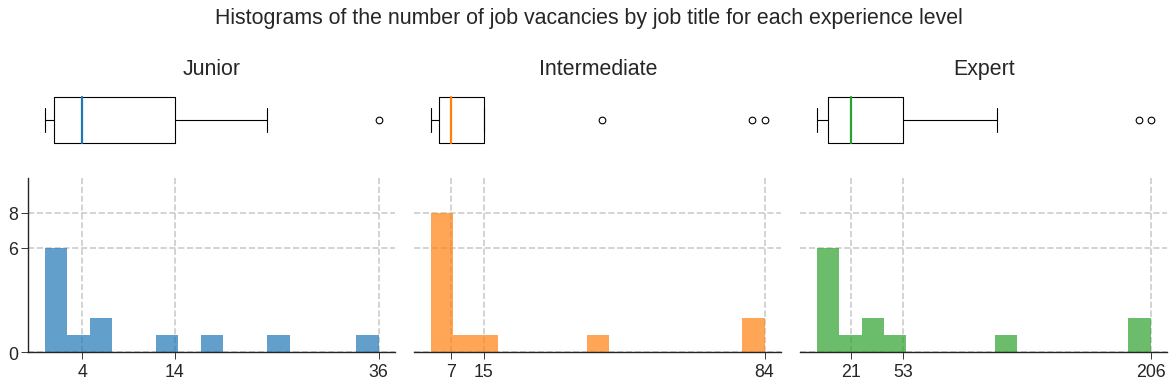

In [171]:
#---------- Figure and Axes ----------#

fig = plt.figure(figsize = (15, 5), dpi = 80)
gs = fig.add_gridspec(nrows = 3, ncols = 3)

plt.suptitle('Histograms of the number of job vacancies by job title for each experience level')

# Box and whiskers plots
ax_box = []
for i in range(3):
    ax_box.append(fig.add_subplot(gs[0, i]))
    
    # Remove spines and ticks and labels
    ax_box[-1].spines[:].set_visible(False)
    ax_box[-1].yaxis.set_visible(False)
    ax_box[-1].xaxis.set_visible(False)
    
# Histograms
ax_hist = []
for i in range(3):
    ax_hist.append(fig.add_subplot(gs[1:, i]))
    
    # Remove spines and ticks and labels
    if i > 0:
        ax_hist[-1].spines[['top', 'right', 'left']].set_visible(False)
        ax_hist[-1].yaxis.set_tick_params(left = False, labelleft = False)
        #ax_hist[-1].yaxis.set_visible(False)
        
    else:
        ax_hist[-1].spines[['top', 'right']].set_visible(False)
        
#---------- Style ----------#

plt.style.use('seaborn-ticks')
plt.rcParams.update({
    'font.size': 16
})

#---------- Box and Whiskers plots ----------#

titles = ['Junior', 'Intermediate', 'Expert']
for i in range(3):
    ax_box[i].set_title(titles[i])
    
    ax_box[i].boxplot(
        df.iloc[:, i],
        vert = False,
        widths = 0.6,
        medianprops = {
            'color': sns.color_palette()[i],
            'linewidth': 2
        }
    )
    
#---------- Histograms ----------#

hist_stats = []
for i in range(3):
    n, bins, patches = ax_hist[i].hist(
        df.iloc[:, i],
        color = sns.color_palette()[i],
        alpha = 0.7,
        bins = 15
    )
    
    hist_stats.append(n)
    
#---------- X and Y labels ----------#

for i in range(3):
    # Y-axis of the histograms
    ax_hist[i].set_ylim(0, np.max(hist_stats) + 2)
    ax_hist[i].set_yticks([0, np.max(hist_stats[0]), np.max(hist_stats)])
    ax_hist[i].grid(axis = 'both', linestyle = '--', linewidth = 1.5)
    
    # X-axis of the histograms
    ax_box[i].set_xlim(ax_hist[i].get_xlim())
    ax_hist[i].set_xticks([np.median(df.iloc[:,i]), np.quantile(df.iloc[:,i], 0.75), np.max(df.iloc[:, i])])

plt.tight_layout()
plt.show()

In [170]:
df.describe().round(1)

,EN,MI,SE
count,13.0,13.0,13.0
mean,8.6,20.8,52.4
std,11.3,29.5,73.1
min,0.0,2.0,0.0
25%,1.0,4.0,7.0
50%,4.0,7.0,21.0
75%,14.0,15.0,53.0
max,36.0,84.0,206.0


The expert level (SE) is the most sought level since its mean, median, and maximum values are the highest of all experience levels, whilst the junior level (EN) is the least since its mean, median, and maximum values are the lowest. Furthermore, most job titles have few vacancies in all experience levels, whilst few jobs concentrate all vacancies as outliers. The intermediate level (MI) is the best example of this. Therefore, I expect that these few job titles form a cluster distant from the others.

Since the maximum of each experience level are quite different

## Proximity Matrix

The **proximity matrix** is essentially a table with the distances between the observations. In this context, distance is a measure of **dissimilarity**. The main properties of the proximity matrix are

- Its diagonal elements are all zeros;
- It is symmetric by the transpose operation. 

Choosing a proper distance measure is the most fundamental task before building a proximity matrix. There are many possible distances, which one has advantages and disadvantages (check [this article](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa) to understand some of the most relevant distances). There are some features of the data we must take into account to choose a distance measure:

- All variables are discrete (positive integers);
- We are mainly concerned with the magnitude differences between observations;
- The variables space has low dimensionality (3 dimensions: EN, MI, and SE).

Let us consider both $ x_i $ and $ y_i $ arbitrary observations of the $i$-th variables. Assuming the features described above, we chose to analyze the following distance measures:

1. **Euclidean distance** $$ d(x_i, y_i) = \sum_{i = 0}^{3} \sqrt{(x_i - y_i)^{2}}; $$

2. **Manhattan distance**
$$ d(x_i, y_i) = \sum_{i = 0}^{3} |x_i - y_i|; $$

3. **Chebyshev distance**
$$ d(x_i, y_i) = \max_i |x_i - y_i|. $$

### Plotting the proximity matrix for the three distance measures

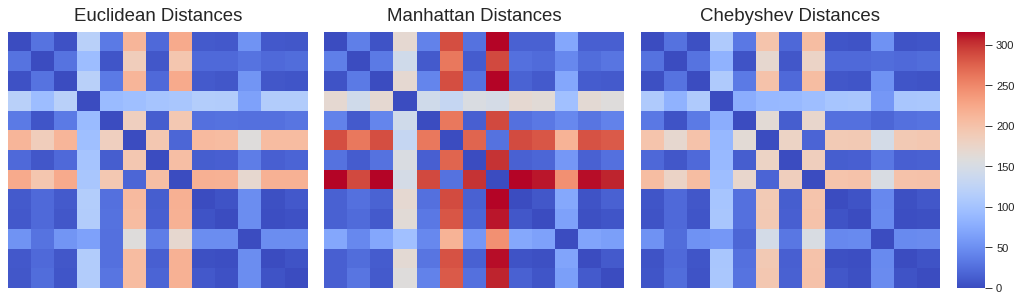

In [42]:
#---- Proximity Matrixes ----#

distances_names = ['euclidean', 'manhattan', 'chebyshev']
proximity_matrices = np.array([pairwise_distances(df, metric = dist) for dist in distances_names])
max_distance = np.max(proximity_matrices)

#----- Figure and Axes ------#

fig = plt.figure(figsize = (13,4), dpi = 80)
gs = fig.add_gridspec(nrows = 1, ncols = 22)

axs = [
    fig.add_subplot(gs[0, 0:7]),    # Euclidian distance
    fig.add_subplot(gs[0, 7:14]),   # Manhattan distance
    fig.add_subplot(gs[0, 14:21]),  # Chebyshev distance
    fig.add_subplot(gs[0, 21]),     # Colorbar
]

#---------- Style -----------#

plt.style.use('seaborn-ticks')
plt.rcParams.update({
    'font.size': 14
})

#-- Plot proximity matrices --#

for i in range(3):
    # Heatmap
    sns.heatmap(
        proximity_matrices[i], 
        ax = axs[i],
        xticklabels = False,
        yticklabels = False,
        cmap = sns.color_palette("coolwarm", as_cmap=True),
        cbar_ax = axs[-1],
        vmin = 0,
        vmax = max_distance
    )

    axs[i].set_title(distances_names[i].capitalize() + ' Distances', pad = 10)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
plt.tight_layout()

The Euclidian, Manhattan, and Chebyshev distances are similar as shown in the heatmaps above. Indeed, these distances came from the same distance measure (Minkowski distance) and, for one-dimensional data, they are all the same. For multi-dimensional data, the Euclidian and Chebyshev distances are less sensitive to differences in more than one variable than the Manhattan distance. Also, since the data only has positive integer variables, the Manhattan distance better suits the case once it only yields positive integer distances. In conclusion, I decided to use the **Manhattan distance** from now on.

In [43]:
proximity_matrix = pd.DataFrame(pairwise_distances(df, metric = 'manhattan'), dtype = 'int64')
pd.merge(proximity_matrix, pd.DataFrame(df.index), how = 'outer', left_index = True, right_index = True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,job_title
0,0,38,6,168,40,287,28,315,15,15,71,14,14,AI Scientist
1,38,0,34,142,10,261,12,289,27,23,45,24,30,Analytics Engineer
2,6,34,0,168,42,287,28,315,17,11,71,12,10,BI Data Analyst
3,168,142,168,0,142,131,154,147,169,163,97,166,160,Data Analyst
4,40,10,42,142,0,261,14,289,27,33,45,30,40,Data Architect
5,287,261,287,131,261,0,273,28,288,282,216,285,279,Data Engineer
6,28,12,28,154,14,273,0,301,15,19,57,16,26,Data Science Manager
7,315,289,315,147,289,28,301,0,316,310,244,313,307,Data Scientist
8,15,27,17,169,27,288,15,316,0,8,72,5,15,ETL Developer
9,15,23,11,163,33,282,19,310,8,0,66,3,7,ML Engineer


## Agglomarative Hierarquical Clustering

3

## K-Means

## Dendrogram (Scipy Cluster Library)

<IPython.core.display.Javascript object>


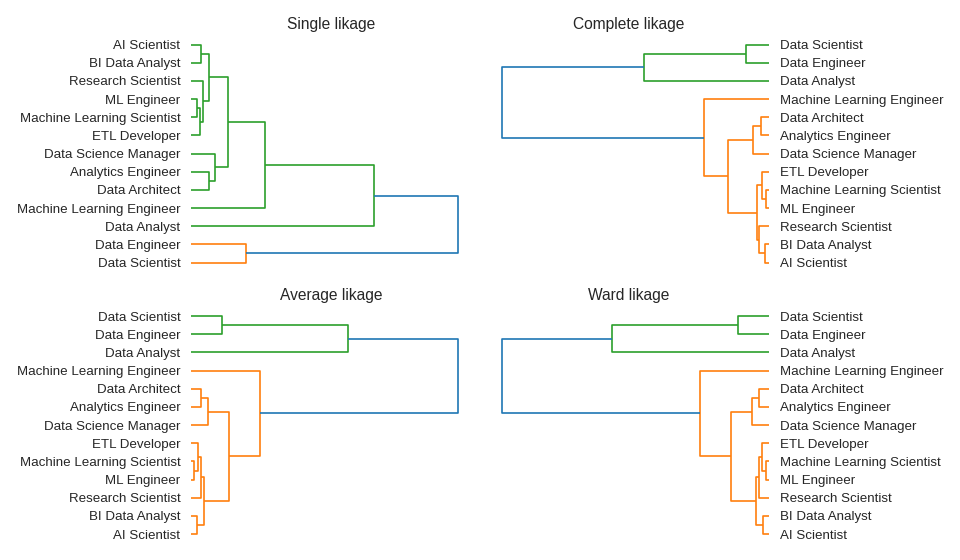

In [144]:
# Subplots
#plt.figure()
fig, axs = plt.subplots(2, 2, figsize = (12, 7), dpi = 80)
plt.style.use('seaborn-white')

# Remove spines
for row_ax in axs:
    for ax in row_ax:
        ax.spines[:].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])

# Single linkage
axs[0,0].set_title('Single likage', loc = 'center', fontsize = 14)
dendrogram = sch.dendrogram(
    sch.linkage(df, method = 'single', optimal_ordering = True), 
    orientation = 'right',
    labels = df.index,
    ax = axs[0,0]
)

# Complete linkage
axs[0,1].set_title('Complete likage', loc = 'center', fontsize = 14)
dendrogram = sch.dendrogram(
    sch.linkage(df, method = 'complete', optimal_ordering = True), 
    orientation = 'left',
    labels = df.index,
    ax = axs[0,1]
)

# Complete linkage
axs[1,0].set_title('Average likage', loc = 'center', fontsize = 14)
dendrogram = sch.dendrogram(
    sch.linkage(df, method = 'average', optimal_ordering = True), 
    orientation = 'right',
    labels = df.index,
    ax = axs[1,0]
)

# Complete linkage
axs[1,1].set_title('Ward likage', loc = 'center', fontsize = 14)
dendrogram = sch.dendrogram(
    sch.linkage(df, method = 'average', optimal_ordering = True), 
    orientation = 'left',
    labels = df.index,
    ax = axs[1,1]
)

# Set layout
plt.tight_layout()
plt.savefig('dendrograms.png', dpi = 100)
plt.show()